In [2]:
import csv
#import sklearn
import matplotlib.pyplot as plt
import pandas as pd
import snowflake.connector
from datetime import datetime
import os
import json

In [4]:
# This chunk uses the snowflake-python connector to load comments db data into a dataframe if the csv does not exist
if os.path.exists("seeds/comments_2022_23.csv"):
    print("file exists, reloading dataframe")
    df_com = pd.read_csv("seeds/comments_2022_23.csv")
else:
    print("Generating csv...")
    conn = snowflake.connector.connect( user='NAMAN.MATHUR@CALIX.COM',
                                        authenticator='externalbrowser',
                                        account='calix',
                                        database='ANALYTICS',
                                        warehouse='USER_WH',
                                        role="DBT_DEVELOPER",
                                        schema='EDW_CE',)
    cur = conn.cursor()
    cur.execute("""
                select * from DBT_DEV_NMATHUR.DBT_NMATHUR.COMMENTS_AGG_2022_23 where COUNT_IN_BETWEEN_GS_DEPLOYMENT_ACTIVITY > 0
                """)
    d = cur.fetchall()
    cols = [] 
    for i in cur.description:
        cols.append(i[0])
    df_com = pd.DataFrame(d, columns=cols)

    df_com.to_csv('seeds/comments_2022_23.csv')


file exists, reloading dataframe


In [116]:
# This chunk uses the snowflake-python connector to load posts db data into a dataframe if the csv does not exist
if os.path.exists("seeds/posts_2022_23.csv"):
    print("file exists, reloading dataframe")
    df_post = pd.read_csv("seeds/posts_2022_23.csv")
else:
    print("Generating csv...")
    conn = snowflake.connector.connect( user='NAMAN.MATHUR@CALIX.COM',
                                        authenticator='externalbrowser',
                                        account='calix',
                                        database='ANALYTICS',
                                        warehouse='USER_WH',
                                        role="DBT_DEVELOPER",
                                        schema='EDW_CE',)
    cur = conn.cursor()
    cur.execute("""
                select * from DBT_DEV_NMATHUR.DBT_NMATHUR.POSTS_AGG_2022_23 where COUNT_IN_BETWEEN_GS_DEPLOYMENT_ACTIVITY > 0
                """)
    d = cur.fetchall()
    cols = [] 
    for i in cur.description:
        cols.append(i[0])
    df_post = pd.DataFrame(d, columns=cols)

    df_post.to_csv('seeds/posts_2022_23.csv')


file exists, reloading dataframe


In [117]:
# Creating the days in between column for posts
day_dif = []
for i in range(len(df_post["ACTIVITY_REPEATED_AT"])):
    if type(df_post["ACTIVITY_REPEATED_AT"][i]) == str:
        activity_day = str(df_post["ACTIVITY_REPEATED_AT"][i])
    else:
        activity_day = str(datetime.today()).split(' ')[0]
    days = str(datetime.strptime(activity_day, '%Y-%m-%d') - datetime.strptime(str(df_post["TS"][i]), '%Y-%m-%d'))
    num = int(days.split(" ")[0])
    day_dif.append(num)

df_post["Day_diff"] = day_dif


# Creating the days in between column for comments
day_dif = []
for i in range(len(df_com["ACTIVITY_REPEATED_AT"])):
    if type(df_com["ACTIVITY_REPEATED_AT"][i]) == str:
        activity_day = str(df_com["ACTIVITY_REPEATED_AT"][i])
    else:
        activity_day = str(datetime.today()).split(' ')[0]
    days = str(datetime.strptime(activity_day, '%Y-%m-%d') - datetime.strptime(str(df_com["TS"][i]), '%Y-%m-%d'))
    num = int(days.split(" ")[0])
    day_dif.append(num)

df_com["Day_diff"] = day_dif


In [127]:
df_post["DEPS"] = pd.to_numeric(df_post["DEPS"])
df_com["DEPS"] = pd.to_numeric(df_com["DEPS"])

df_post["DEPS_DIFF"] = df_post.groupby(['CUSTOMER'])['DEPS'].diff()
df_com["DEPS_DIFF"] = df_com.groupby(['CUSTOMER'])['DEPS'].diff()

df_post = df_post.sort_values(by=['CUSTOMER', 'TS'])
df_com = df_com.sort_values(by=['CUSTOMER', 'TS'])

df_post.to_csv('test.csv')

<Figure size 640x480 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

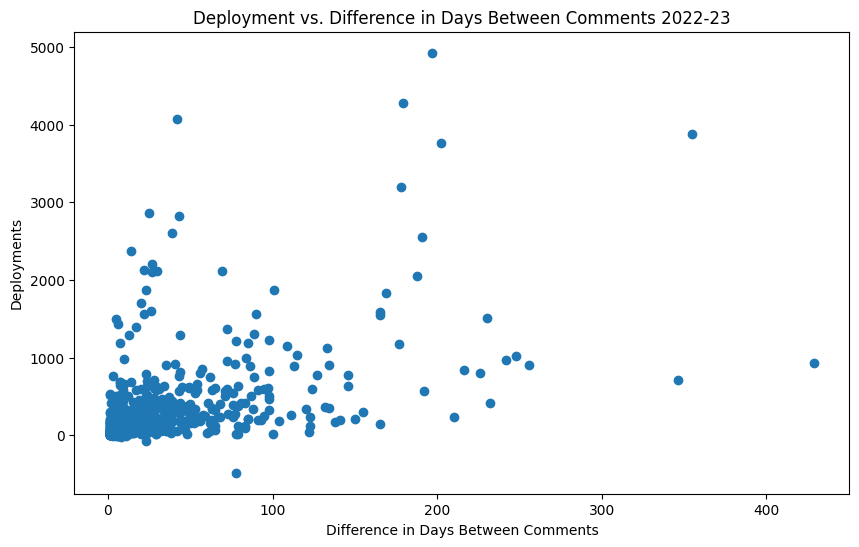

In [132]:
# Comment Visualizations
plt.clf()
plt.figure(figsize=(10,6))
plt.scatter(df_com["TS"], df_com["COUNT_IN_BETWEEN_GS_DEPLOYMENT_ACTIVITY"])
plt.xlabel("Comment Timestamp")
plt.ylabel("Instances of Deployment Between Next Comment")
plt.title("Instances of Deployment vs. Comment Ts 2022-23")
plt.savefig("Visualizations/Instances_vs_Comments_22_23.png")


plt.clf()
plt.figure(figsize=(10,6))
plt.scatter(df_com["Day_diff"], df_com["COUNT_IN_BETWEEN_GS_DEPLOYMENT_ACTIVITY"])
plt.xlabel("Difference in Days Between Comments")
plt.ylabel("Instances of Deployment")
plt.title("Instances of Deployment vs. Difference in Days Between Comments 2022-23")
plt.savefig("Visualizations/Instances_vs_DayDiff_Comments_22_23.png")

plt.clf()
plt.figure(figsize=(10,6))
plt.scatter(df_com["Day_diff"], df_com["DEPS_DIFF"])
plt.xlabel("Difference in Days Between Comments")
plt.ylabel("Deployments")
plt.title("Deployment vs. Difference in Days Between Comments 2022-23")
plt.savefig("Visualizations/DepsDiff_vs_DayDiff_Comments_22_23.png")

<Figure size 640x480 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

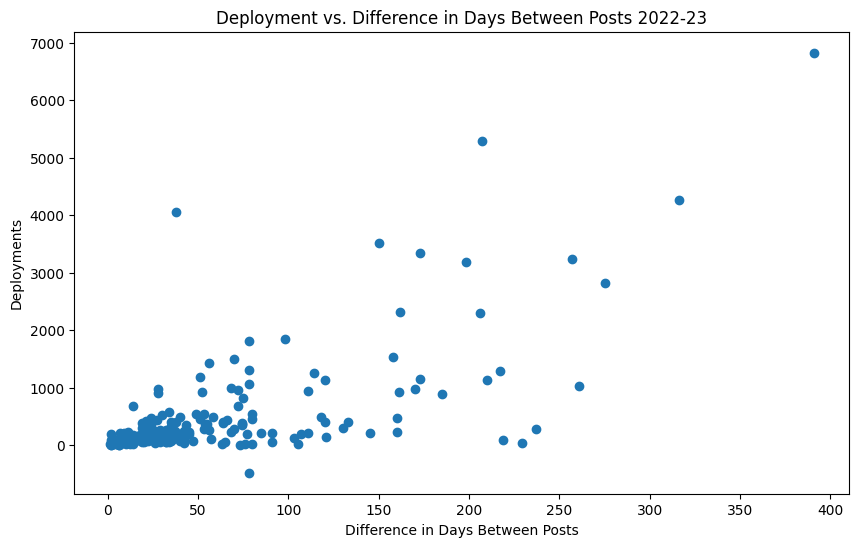

In [130]:
# Post Visualizations
plt.clf()
plt.figure(figsize=(10,6))
plt.scatter(df_post["TS"], df_post["COUNT_IN_BETWEEN_GS_DEPLOYMENT_ACTIVITY"])
plt.xlabel("Post Timestamp")
plt.ylabel("Instances of Deployment Between Next Post")
plt.title("Instances of Deployment vs. Post Ts 2022-23")
plt.savefig("Visualizations/Instances_vs_Posts_22_23.png")

plt.clf()
plt.figure(figsize=(10,6))
plt.scatter(df_post["Day_diff"], df_post["COUNT_IN_BETWEEN_GS_DEPLOYMENT_ACTIVITY"])
plt.xlabel("Difference in Days Between Posts")
plt.ylabel("Instances of Deployment")
plt.title("Instances of Deployment vs. Difference in Days Between Posts 2022-23")
plt.savefig("Visualizations/Instances_vs_DayDiff_Posts_22_23.png")

plt.clf()
plt.figure(figsize=(10,6))
plt.scatter(df_post["Day_diff"], df_post["DEPS_DIFF"])
plt.xlabel("Difference in Days Between Posts")
plt.ylabel("Deployments")
plt.title("Deployment vs. Difference in Days Between Posts 2022-23")
plt.savefig("Visualizations/DepsDiff_vs_DayDiff_Posts_22_23.png")

In [185]:
# Retrieves info about top 5 activities
if os.path.exists("seeds/top_five_act.csv"):
    print("file exists, reloading dataframe")
    df_top_act = pd.read_csv("seeds/top_five_act.csv")
else:
    print("Generating csv...")
    conn = snowflake.connector.connect( user='NAMAN.MATHUR@CALIX.COM',
                                        authenticator='externalbrowser',
                                        account='calix',
                                        database='ANALYTICS',
                                        warehouse='USER_WH',
                                        role="DBT_DEVELOPER",
                                        schema='EDW_CE',)
    cur = conn.cursor()
    cur.execute("""
                select a.* from DBT_DEV_NMATHUR.DBT_NMATHUR.TOP_FIVE_ACTIVITIES t left join DBT_DEV_NMATHUR.DBT_NMATHUR.ACTIVITIES_2022_23 a on t.customer=a.customer
                """)
    d = cur.fetchall()
    cols = [] 
    for i in cur.description:
        cols.append(i[0])
    df_top_act = pd.DataFrame(d, columns=cols)

    df_top_act.to_csv('seeds/top_five_act.csv')


# Retrieves info about top 5 deployments
if os.path.exists("seeds/top_five_dep.csv"):
    print("file exists, reloading dataframe")
    df_top_deps = pd.read_csv("seeds/top_five_dep.csv")
else:
    print("Generating csv...")
    conn = snowflake.connector.connect( user='NAMAN.MATHUR@CALIX.COM',
                                        authenticator='externalbrowser',
                                        account='calix',
                                        database='ANALYTICS',
                                        warehouse='USER_WH',
                                        role="DBT_DEVELOPER",
                                        schema='EDW_CE',)
    cur = conn.cursor()
    cur.execute("""
                select a.* from DBT_DEV_NMATHUR.DBT_NMATHUR.TOP_FIVE_DEPS t left join DBT_DEV_NMATHUR.DBT_NMATHUR.ACTIVITIES_2022_23 a on t.customer=a.customer
                """)
    d = cur.fetchall()
    cols = [] 
    for i in cur.description:
        cols.append(i[0])
    df_top_deps = pd.DataFrame(d, columns=cols)

    df_top_deps.to_csv('seeds/top_five_dep.csv')


# all activities
if os.path.exists("seeds/all_clients_2022_23.csv"):
    print("file exists, reloading dataframe")
    df_all = pd.read_csv("seeds/all_clients_2022_23.csv")
else:
    print("Generating csv...")
    conn = snowflake.connector.connect( user='NAMAN.MATHUR@CALIX.COM',
                                        authenticator='externalbrowser',
                                        account='calix',
                                        database='ANALYTICS',
                                        warehouse='USER_WH',
                                        role="DBT_DEVELOPER",
                                        schema='EDW_CE',)
    cur = conn.cursor()
    cur.execute("""
                select * from DBT_DEV_NMATHUR.DBT_NMATHUR.ACTIVITIES_2022_23
                """)
    d = cur.fetchall()
    cols = [] 
    for i in cur.description:
        cols.append(i[0])
    df_all = pd.DataFrame(d, columns=cols)

    df_all.to_csv('seeds/all_clients_2022_23.csv')    


Generating csv...
Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://calix.okta.com/app/snowflake/exk1fkyt56xzVeE891d8/sso/saml?SAMLRequest=jZLLbtswEEV%2FRWDXFim%2FQ1gO%2FEgQoW5qxEpaeMdIY5swRaocKrL79aX8KNJFgu4I8l6embkzuj0UKngDi9LomEQhIwHozORSb2PynN63hiRAJ3QulNEQkyMguR2PUBSq5JPK7fQT%2FKoAXeA%2F0sibh5hUVnMjUCLXogDkLuOrybcFb4eMC0SwzuPIxZKj9KydcyWntK7rsO6Exm5pmzFG2Q31qkbyhbxDlJ8zSmucyYy6Wg6%2Bpw8QEWXdBuEVnrC8GKdSn0fwGeX1LEL%2BkKbL1vL7KiXB5NrdzGisCrArsG8yg%2BenxbkA9BXMJovkZ4ja1Bsl9pCZoqyc%2Fyn0J7qBnCqzlX4%2ByTwm5V7mrDNYv7YXbprvZt3F%2Bi7prYvZj6mQjwkO61p8hdVG9PoPuyXLSPByTbPdpJkgVpDoJkPnr1i702LDFovSaMAZ471B2O921ySY%2BwylFu7kvBaaCSUPodk7cSpNlCX9WzWFwz7a7I%2Bu1z%2F8foG74U2UDymioU1A5Lwj%2FIS34%2F%2FpfETfOy4r9uinnsyXRsnsGNwbWwj3cShRGJ1uZN7anKQcCiHVJM8tIPpwlDL1zIJwfpOdrYDQ8Zn67y6P%2FwA%3D&RelaySt

<Figure size 640x480 with 0 Axes>

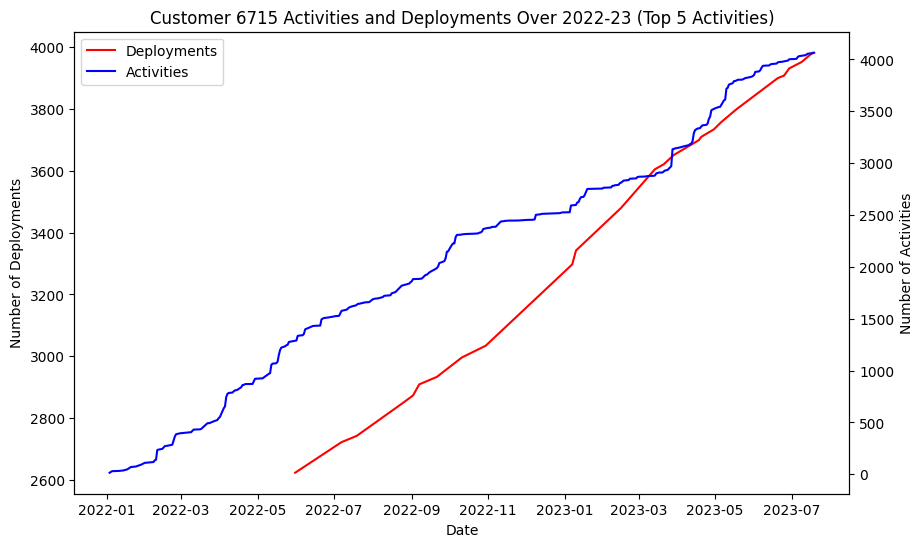

<Figure size 640x480 with 0 Axes>

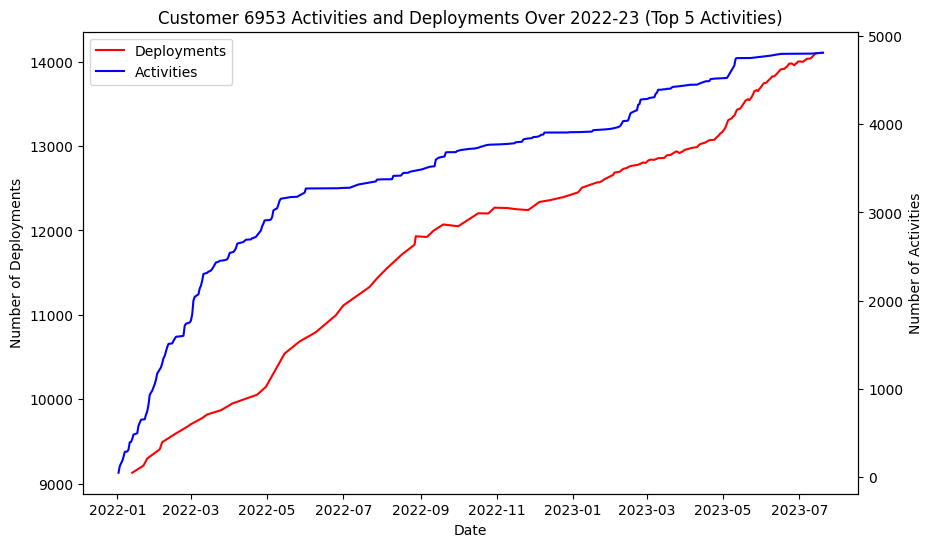

<Figure size 640x480 with 0 Axes>

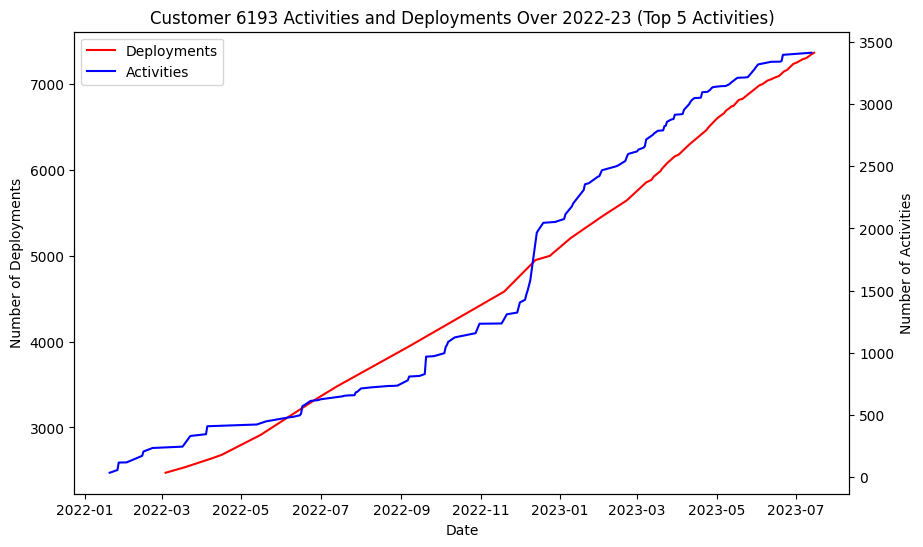

<Figure size 640x480 with 0 Axes>

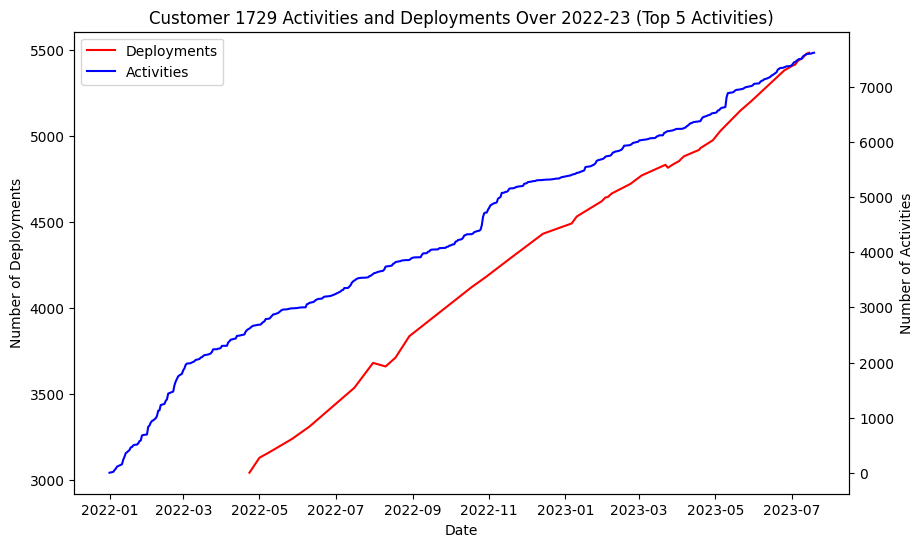

<Figure size 640x480 with 0 Axes>

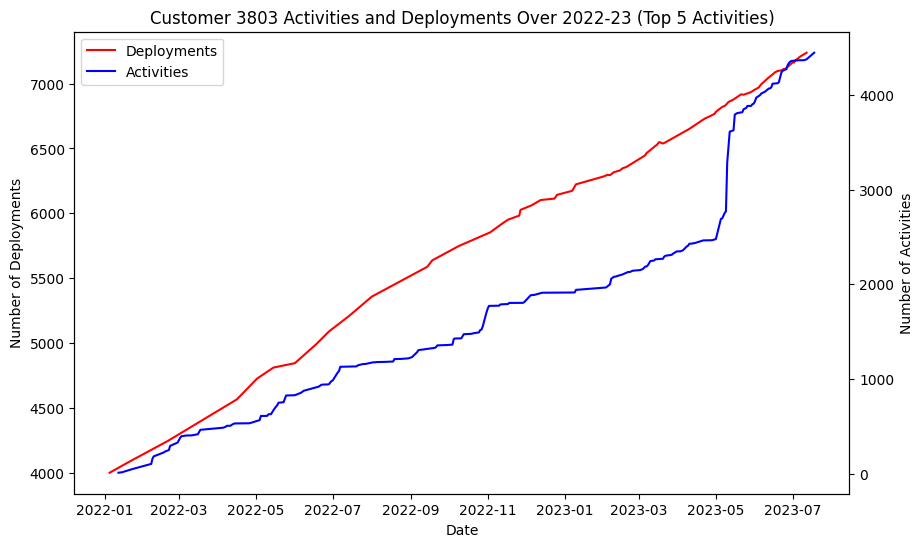

In [70]:
# Top 5 activity graphs
act_customers = df_top_act['CUSTOMER'].unique()
deps = {}
acts = {}


for customer in act_customers:
    for index, row in df_top_act.iterrows():
        if row['CUSTOMER'] == customer:
            if row['ACTIVITY'] == 'gs_deployment':
                feature = json.loads(row['FEATURE_JSON'])
                dep_count = dep_count + 1
                dep_sum = dep_sum + feature['cumulative_value']
                avg = float(dep_sum / dep_count)
                deps[row['TS']] = avg
            else:
                acts[row['TS']] = acts.get(row['TS'], 0) + 1

    acts = dict(sorted(acts.items(), key=lambda t:t[0]))
    deps = dict(sorted(deps.items(), key=lambda t:t[0]))   

    act_dates = list(acts.keys())
    act_nums = acts.values()
    dep_dates = deps.keys()
    dep_nums = deps.values()

    for i in range(1, len(act_dates)):
        acts[act_dates[i]] = acts[act_dates[i]] + acts[act_dates[i-1]] 

    plt.clf()
    plt.rcdefaults()
    fig,ax = plt.subplots()
    fig.set_size_inches(10, 6)
    l1 = ax.plot(dep_dates, dep_nums, color='red', label='Deployments')
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of Deployments')
    ax2=ax.twinx()
    l2 = ax2.plot(act_dates, act_nums, color='blue', label='Activities')
    ax2.set_ylabel("Number of Activities")
    ax.set_title('Customer ' + str(customer) + ' Activities and Deployments Over 2022-23 (Top 5 Activities)')
    lns = l1 + l2
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc='upper left')
    plt.show()
    fig.savefig('Visualizations/T5_Acts_Customer_Moving_Average_' + str(customer) + '_Deployments_and_Activities_2022_23')
    deps.clear()
    acts.clear()
    dep_count = 0
    dep_sum = 0
    act_count = 0
    act_sum = 0

<Figure size 640x480 with 0 Axes>

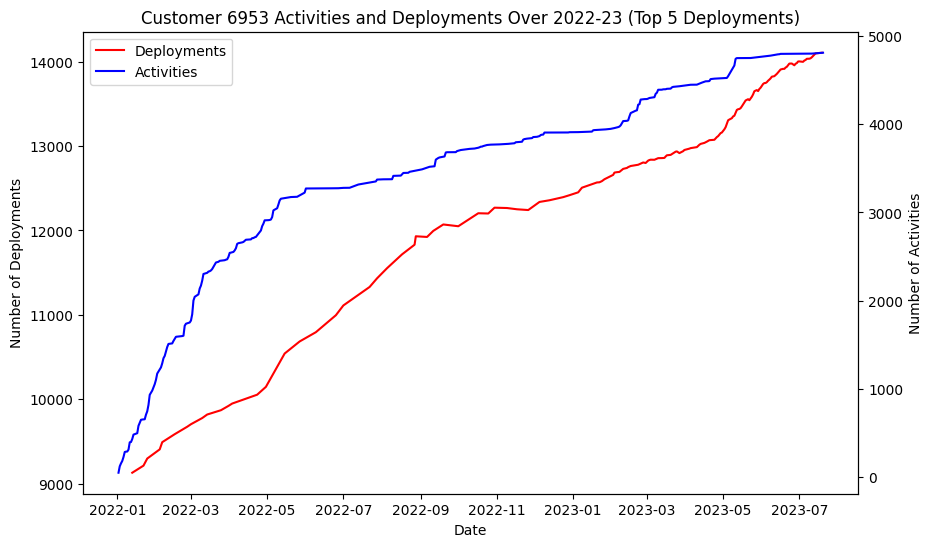

<Figure size 640x480 with 0 Axes>

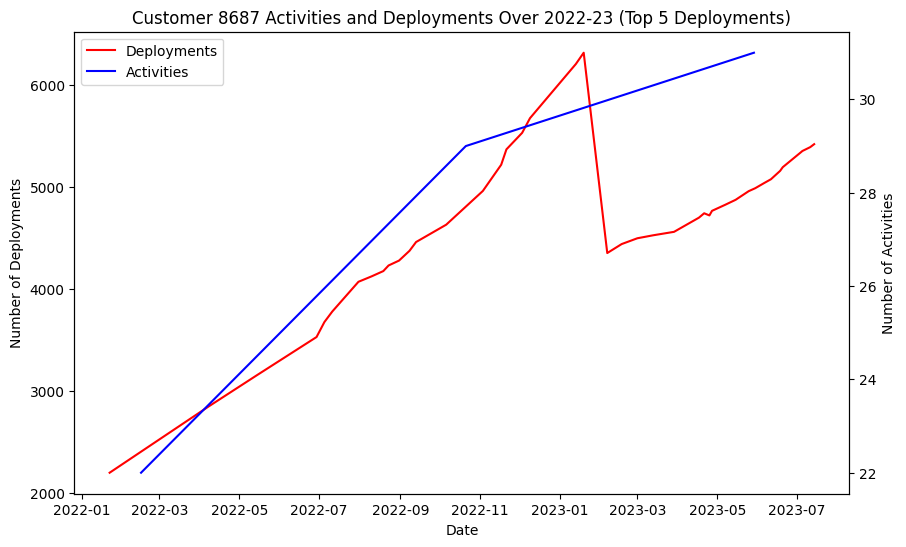

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://calix.okta.com/app/snowflake/exk1fkyt56xzVeE891d8/sso/saml?SAMLRequest=jZLdbuIwEIVfJfJeEzuBtmABFT%2BLQKIsgrTq9s5NBrBw7KzHIdCnXxPKqnvRqneWfc7MNz7TvT%2FmKjiARWl0j0QhIwHo1GRSb3vkMZk02iRAJ3QmlNHQIydAct%2FvoshVwQel2%2BkV%2FCkBXeALaeT1Q4%2BUVnMjUCLXIgfkLuXrwcOcxyHjhTXOpEaRD5avHQIRrPOEV0uG0uPtnCs4pVVVhVUzNHZLY8YYZR3qVWfJj6v%2B6Gf6RB9R1jrrvcLLl%2B9sQ6kvX%2FAV1utFhHyaJMvG8tc6IcHgijoyGssc7BrsQabwuJpfANATjAbz2XOI2lQbJfaQmrwona8U%2BhPdQEaV2Uo%2F7GzcI8VeZqfXoT5MlzLflsPmw3RXrHa2EnoiFgurk%2BEmy%2BHU0uPO75dWSoKna5rxOc0ZYgkzfc7Q%2BSsWNxvsrhGzJGb85o43b8NOq%2FNCgrHPUGrhaucVNBVKHkOzd6JGE0VB%2F1FTOO6jzf7kbm6Pb0%2Fws92JsjZFNPQcKLnsCK%2Fb2%2F53Ju%2FSj473FVv4X5%2BNl0bJ9BRMjM2F%2BzyUKIzqG5k1NrWUQy6kGmSZBUQfjlKmGlkQzm%2BysyUQ2r90%2FX%2BX%2B38B&RelayState=5562

<Figure size 640x480 with 0 Axes>

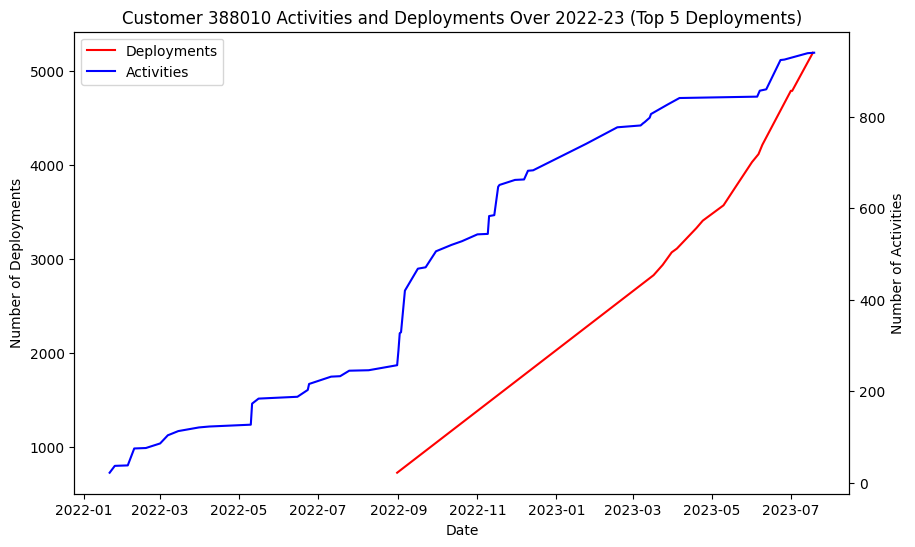

<Figure size 640x480 with 0 Axes>

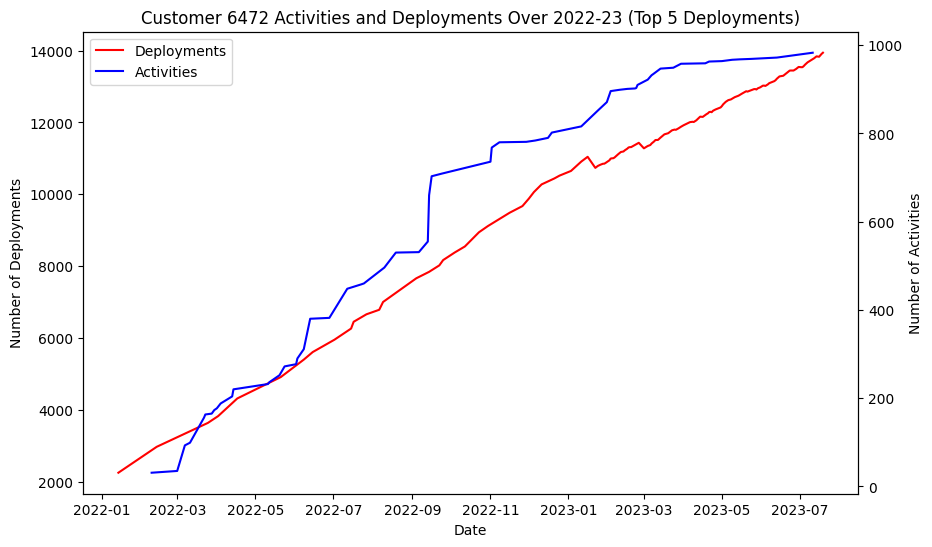

<Figure size 640x480 with 0 Axes>

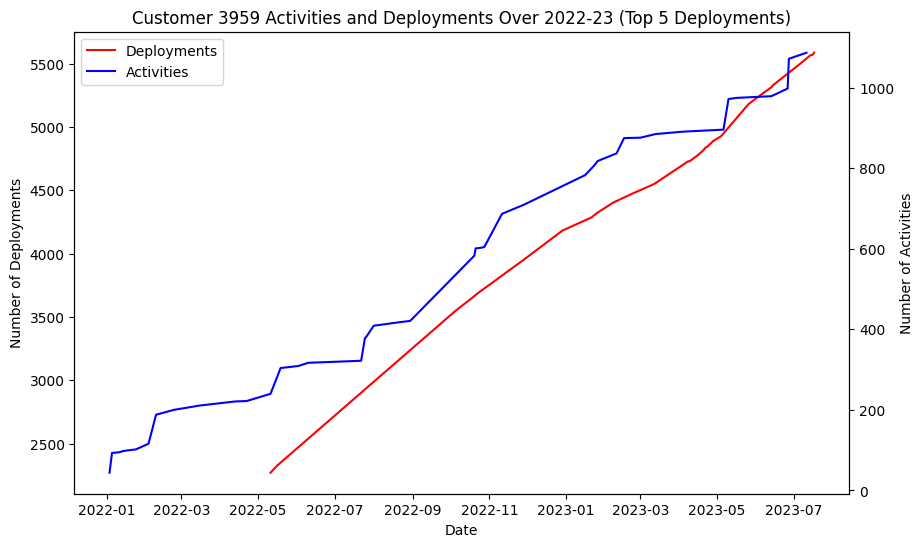

In [71]:
# Top 5 deployment graphs
deps_customers = df_top_deps['CUSTOMER'].unique()
deps = {}
acts = {}

for customer in deps_customers:
    for index, row in df_top_deps.iterrows():
        if row['CUSTOMER'] == customer:
            if row['ACTIVITY'] == 'gs_deployment':
                feature = json.loads(row['FEATURE_JSON'])
                deps[row['TS']] = feature['cumulative_value']
            else:
                acts[row['TS']] = acts.get(row['TS'], 0) + 1

    acts = dict(sorted(acts.items(), key=lambda t:t[0]))
    deps = dict(sorted(deps.items(), key=lambda t:t[0]))        

    act_dates = list(acts.keys())
    act_nums = acts.values()
    dep_dates = deps.keys()
    dep_nums = deps.values()

    for i in range(1, len(act_dates)):
        acts[act_dates[i]] = acts[act_dates[i]] + acts[act_dates[i-1]] 

    plt.clf()
    plt.rcdefaults()
    fig,ax = plt.subplots()
    fig.set_size_inches(10, 6)
    l1 = ax.plot(dep_dates, dep_nums, color='red', label='Deployments')
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of Deployments')
    ax2=ax.twinx()
    l2 = ax2.plot(act_dates, act_nums, color='blue', label='Activities')
    ax2.set_ylabel("Number of Activities")
    ax.set_title('Customer ' + str(customer) + ' Activities and Deployments Over 2022-23 (Top 5 Deployments)')
    lns = l1 + l2
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc='upper left')
    plt.show()
    fig.savefig('Visualizations/T5_Deps_Customer_' + str(customer) + '_Deployments_and_Activities_2022_23')
    deps.clear()
    acts.clear()

<Figure size 640x480 with 0 Axes>

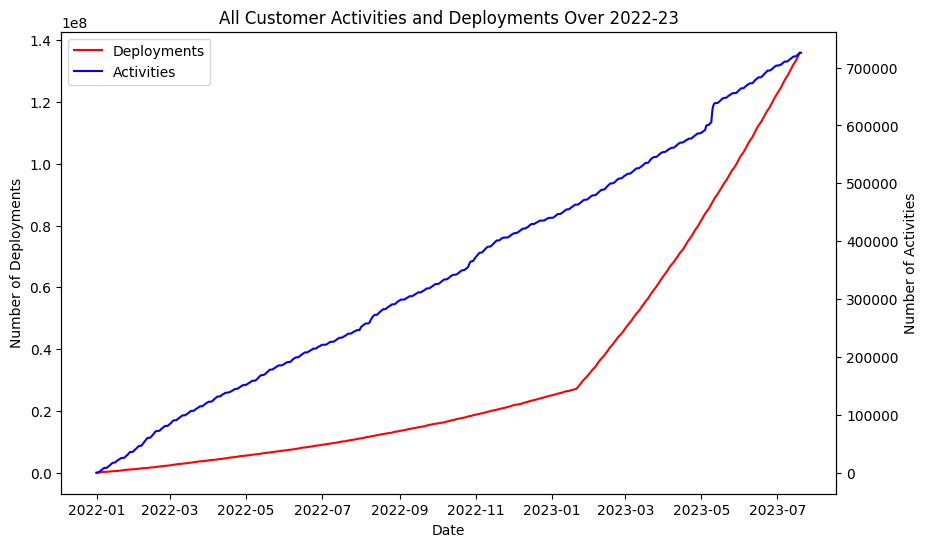

In [258]:
# All activities graph
deps = {}
acts = {}

for index, row in df_all.iterrows():
    if row['ACTIVITY'] == 'gs_deployment':
        feature = json.loads(row['FEATURE_JSON'])
        deps[row['TS']] = deps.get(row['TS'], 0) + feature['cumulative_value']
    else:
        acts[row['TS']] = acts.get(row['TS'], 0) + 1

acts = dict(sorted(acts.items(), key=lambda t:t[0]))
deps = dict(sorted(deps.items(), key=lambda t:t[0]))        

act_dates = list(acts.keys())
dep_dates = list(deps.keys())

for i in range(1, len(act_dates)):
    acts[act_dates[i]] = acts[act_dates[i]] + acts[act_dates[i-1]] 

for i in range(1, len(dep_dates)):
    deps[dep_dates[i]] = deps[dep_dates[i]] + deps[dep_dates[i-1]] 


act_nums = acts.values()
dep_nums = deps.values()

dep_dates = pd.to_datetime(dep_dates)
act_dates = pd.to_datetime(act_dates)

plt.clf()
plt.rcdefaults()
fig,ax = plt.subplots()
fig.set_size_inches(10, 6)
l1 = ax.plot(dep_dates, dep_nums, color='red', label='Deployments')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Deployments')
ax2=ax.twinx()
l2 = ax2.plot(act_dates, act_nums, color='blue', label='Activities')
ax2.set_ylabel("Number of Activities")
ax.set_title('All Customer Activities and Deployments Over 2022-23')
lns = l1 + l2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc='upper left')
plt.show()
fig.savefig('Visualizations/All_Customer_' + str(customer)
 + '_Deployments_and_Activities_2022_23')
deps.clear()
acts.clear()

C:\Users\nmathur\AppData\Local\Temp\ipykernel_21896\2278186000.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_deps['NUM_DEPS'] = ([json.loads(x)['cumulative_value'] for x in df_all_deps["FEATURE_JSON"]])


<Figure size 640x480 with 0 Axes>

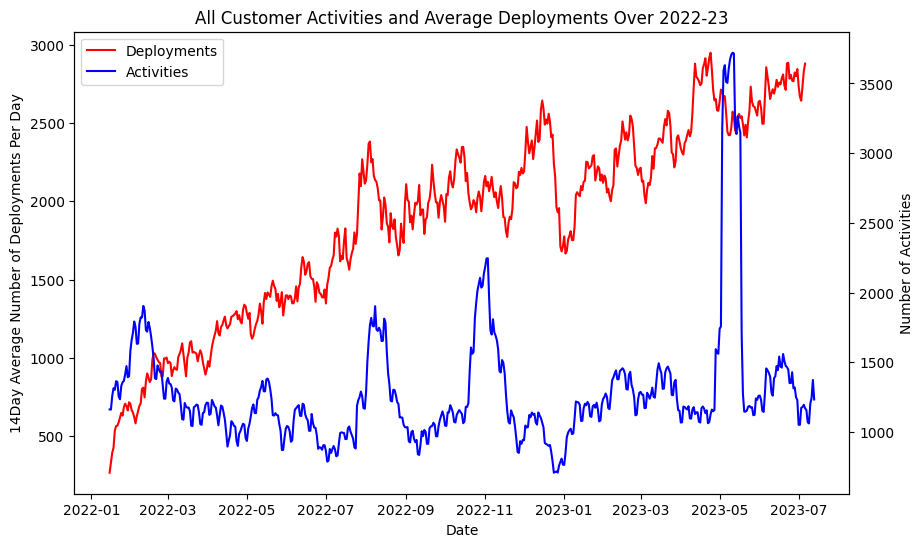

In [221]:
# moving average data for all companies activities vs deployments

df_all_deps = df_all[df_all['ACTIVITY'] == 'gs_deployment']
df_all_acts = df_all[df_all['ACTIVITY'] != 'gs_deployment']

# activities
df_all_acts = df_all_acts.groupby(by=['TS']).ACTIVITY.count().reset_index()

# deps
df_all_deps['NUM_DEPS'] = ([json.loads(x)['cumulative_value'] for x in df_all_deps["FEATURE_JSON"]])
df_all_deps = df_all_deps.groupby(by=['CUSTOMER','TS']).NUM_DEPS.sum().reset_index()
df_all_deps['NUM_DEPS'] = pd.to_numeric(df_all_deps['NUM_DEPS'])
df_all_deps["DAY_DIFFS"] = df_all_deps.groupby(by=['CUSTOMER']).NUM_DEPS.diff().fillna(0)
df_all_deps[(df_all_deps['CUSTOMER'] == '1767')]


dates = pd.Series(df_all_acts["TS"].unique(), name="TS")
companies = pd.Series(df_all_deps["CUSTOMER"].unique(), name="CUSTOMER")
combined = pd.merge(dates, companies, how='cross')
combined = combined.sort_values(by=['CUSTOMER', 'TS'])
combined = pd.merge(combined, df_all_deps, left_on=["CUSTOMER", "TS"], right_on=["CUSTOMER", "TS"], how='left').fillna(0)

days = 14
s = days // 2

combined['avgs'] = combined.groupby('CUSTOMER')['DAY_DIFFS'].shift(-s).rolling((2*s)+1).mean().reset_index(0, drop=True)
combined.to_csv("merged")
final = combined.groupby(by=['TS']).avgs.sum().reset_index()
final.to_csv("final")

# activity avgs
df_all_acts['avgs'] = df_all_acts['ACTIVITY'].shift(-s).rolling((2*s)+1).mean().reset_index(0, drop=True)

df_all_acts['TS'] = pd.to_datetime(df_all_acts['TS'])
final['TS'] = pd.to_datetime(final['TS'])


plt.clf()
plt.rcdefaults()
fig,ax = plt.subplots()
fig.set_size_inches(10, 6)
l1 = ax.plot(final['TS'][days:-days], final["avgs"][days:-days], color='red', label='Deployments')
ax.set_xlabel('Date')
ax.set_ylabel(str(days) + 'Day Average Number of Deployments Per Day')
ax2=ax.twinx()
l2 = ax2.plot(df_all_acts['TS'], df_all_acts["avgs"], color='blue', label='Activities')
ax2.set_ylabel("Number of Activities")
ax.set_title('All Customer Activities and Average Deployments Over 2022-23')
lns = l1 + l2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc='upper left')
plt.show()
fig.savefig('Visualizations/' + str(days) + '_Day_All_Customer_Deployments_and_Activities_2022_23')

C:\Users\nmathur\AppData\Local\Temp\ipykernel_21896\244909330.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deps['NUM_DEPS'] = ([json.loads(x)['cumulative_value'] for x in deps["FEATURE_JSON"]])


<Figure size 640x480 with 0 Axes>

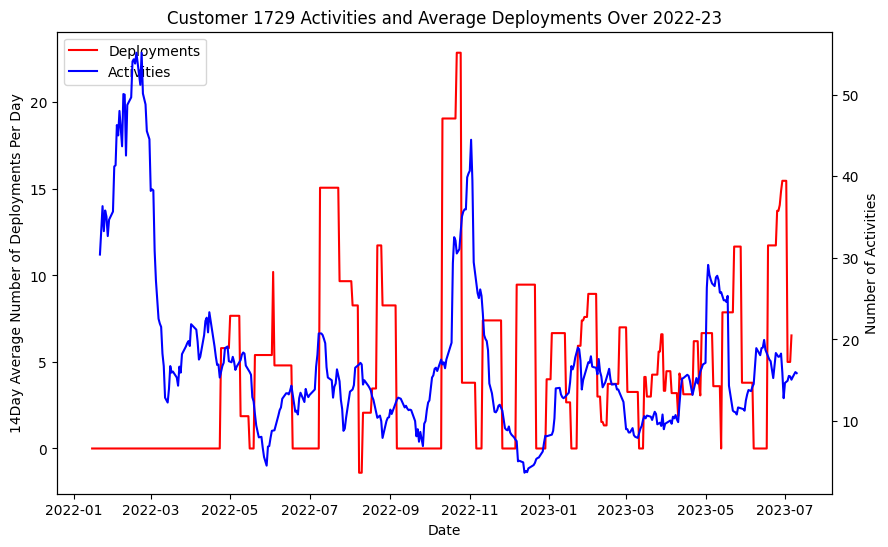

C:\Users\nmathur\AppData\Local\Temp\ipykernel_21896\244909330.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deps['NUM_DEPS'] = ([json.loads(x)['cumulative_value'] for x in deps["FEATURE_JSON"]])


<Figure size 640x480 with 0 Axes>

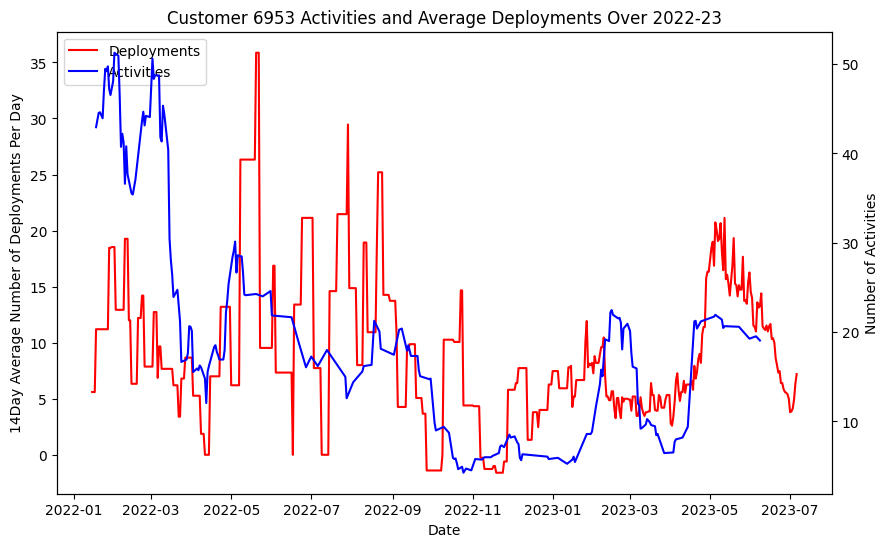

C:\Users\nmathur\AppData\Local\Temp\ipykernel_21896\244909330.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deps['NUM_DEPS'] = ([json.loads(x)['cumulative_value'] for x in deps["FEATURE_JSON"]])


<Figure size 640x480 with 0 Axes>

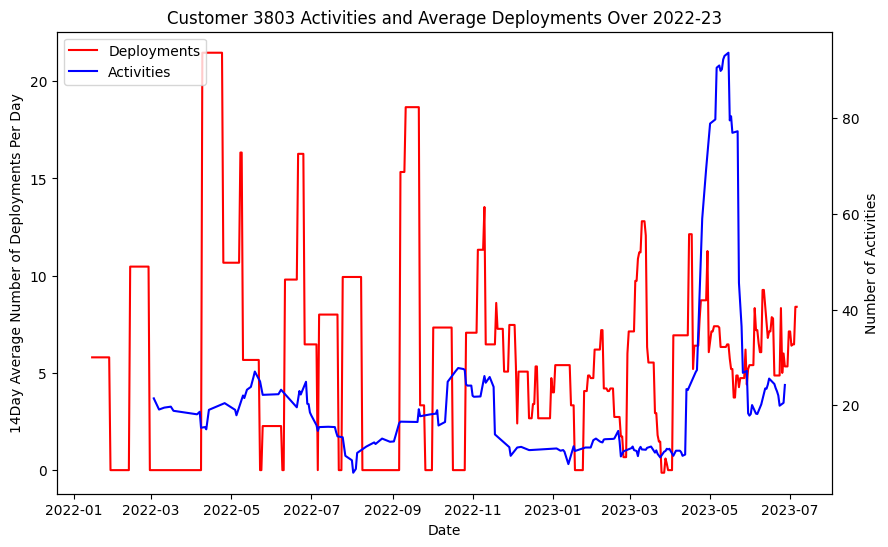

C:\Users\nmathur\AppData\Local\Temp\ipykernel_21896\244909330.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deps['NUM_DEPS'] = ([json.loads(x)['cumulative_value'] for x in deps["FEATURE_JSON"]])


<Figure size 640x480 with 0 Axes>

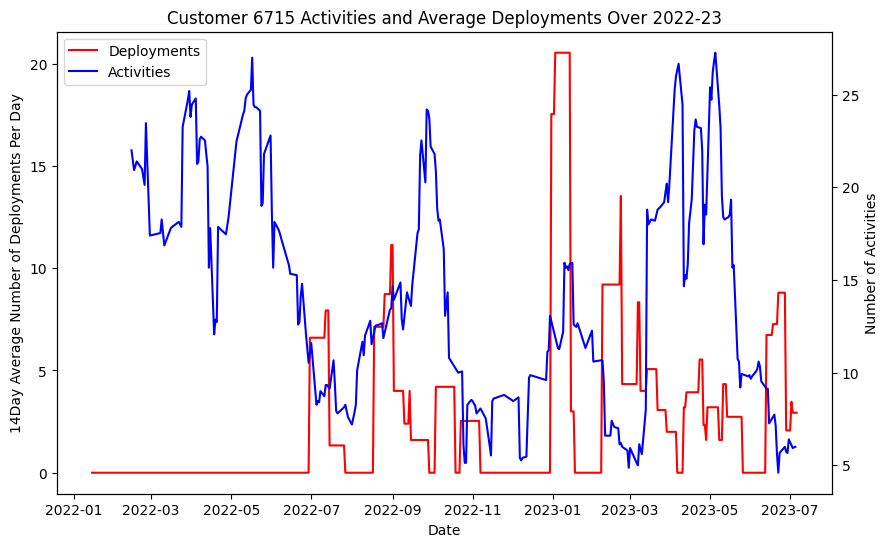

C:\Users\nmathur\AppData\Local\Temp\ipykernel_21896\244909330.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deps['NUM_DEPS'] = ([json.loads(x)['cumulative_value'] for x in deps["FEATURE_JSON"]])


<Figure size 640x480 with 0 Axes>

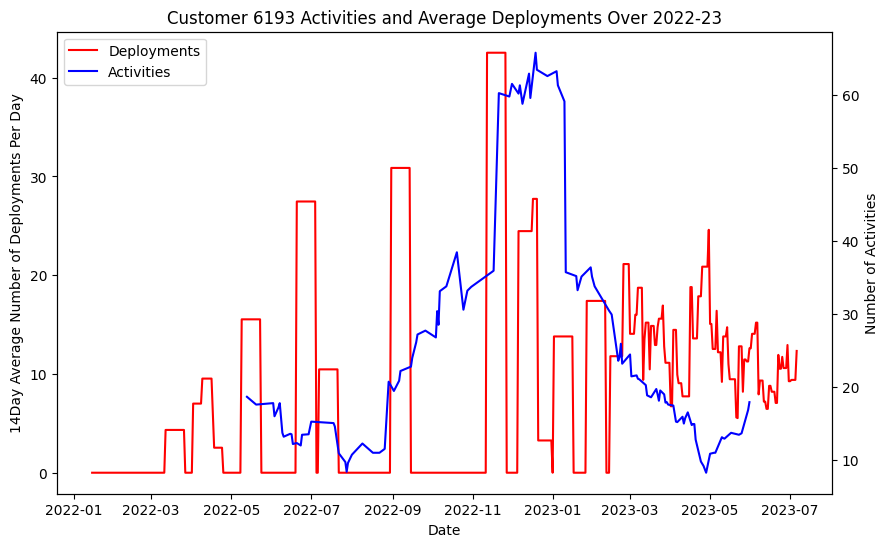

In [255]:
# Moving averages for top 5 activities
customers = df_top_act["CUSTOMER"].unique()

for customer in customers:

    df = df_top_act[df_top_act['CUSTOMER'] == customer]
    deps = df[df['ACTIVITY'] == 'gs_deployment']
    acts = df[df['ACTIVITY'] != 'gs_deployment']

    # act
    acts = acts.groupby(by=['TS']).ACTIVITY.count().reset_index()

    # deps
    deps['NUM_DEPS'] = ([json.loads(x)['cumulative_value'] for x in deps["FEATURE_JSON"]])
    deps = deps.groupby(by=['CUSTOMER','TS']).NUM_DEPS.sum().reset_index()
    deps['NUM_DEPS'] = pd.to_numeric(deps['NUM_DEPS'])
    deps["DAY_DIFFS"] = deps.groupby(by=['CUSTOMER']).NUM_DEPS.diff().fillna(0)

    dates = pd.Series(df_all_acts["TS"].unique(), name="TS")
    companies = pd.Series(deps["CUSTOMER"].unique(), name="CUSTOMER")
    combined = pd.merge(dates, companies, how='cross')
    combined = combined.sort_values(by=['CUSTOMER', 'TS'])
    deps['TS'] = pd.to_datetime(deps['TS'])
    combined = pd.merge(combined, deps, left_on=["CUSTOMER", "TS"], right_on=["CUSTOMER", "TS"], how='left').fillna(0)

    days = 14
    s = days // 2

    combined['avgs'] = combined.groupby('CUSTOMER')['DAY_DIFFS'].shift(-s).rolling((2*s)+1).mean().reset_index(0, drop=True)
    final = combined.groupby(by=['TS']).avgs.sum().reset_index()
    
    # activity avgs
    acts['avgs'] = acts['ACTIVITY'].shift(-s).rolling((2*s)+1).mean().reset_index(0, drop=True)

    acts['TS'] = pd.to_datetime(acts['TS'])
    final['TS'] = pd.to_datetime(final['TS'])

    plt.clf()
    plt.rcdefaults()
    fig,ax = plt.subplots()
    fig.set_size_inches(10, 6)
    l1 = ax.plot(final['TS'][days:-days], final["avgs"][days:-days], color='red', label='Deployments')
    ax.set_xlabel('Date')
    ax.set_ylabel(str(days) + 'Day Average Number of Deployments Per Day')
    ax2=ax.twinx()
    l2 = ax2.plot(acts['TS'], acts["avgs"], color='blue', label='Activities')
    ax2.set_ylabel("Number of Activities")
    ax.set_title('Customer ' + str(customer) + ' Activities and Average Deployments Over 2022-23')
    lns = l1 + l2
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc='upper left')
    plt.show()
    fig.savefig('Visualizations/Top_5_acts_' + str(days) + '_Day_Customer_' + str(customer) + '_Deployments_and_Activities_2022_23')
    
    



C:\Users\nmathur\AppData\Local\Temp\ipykernel_21896\59215926.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deps['NUM_DEPS'] = ([json.loads(x)['cumulative_value'] for x in deps["FEATURE_JSON"]])


<Figure size 640x480 with 0 Axes>

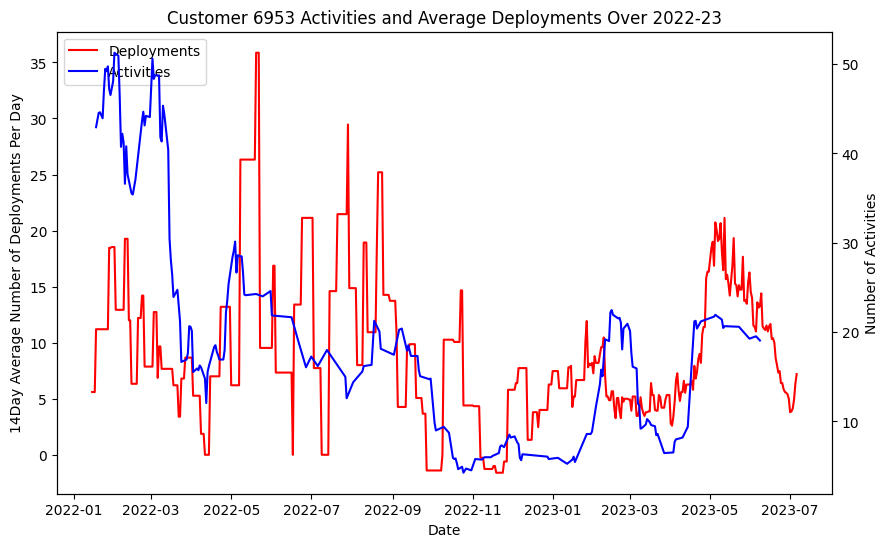

C:\Users\nmathur\AppData\Local\Temp\ipykernel_21896\59215926.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deps['NUM_DEPS'] = ([json.loads(x)['cumulative_value'] for x in deps["FEATURE_JSON"]])


<Figure size 640x480 with 0 Axes>

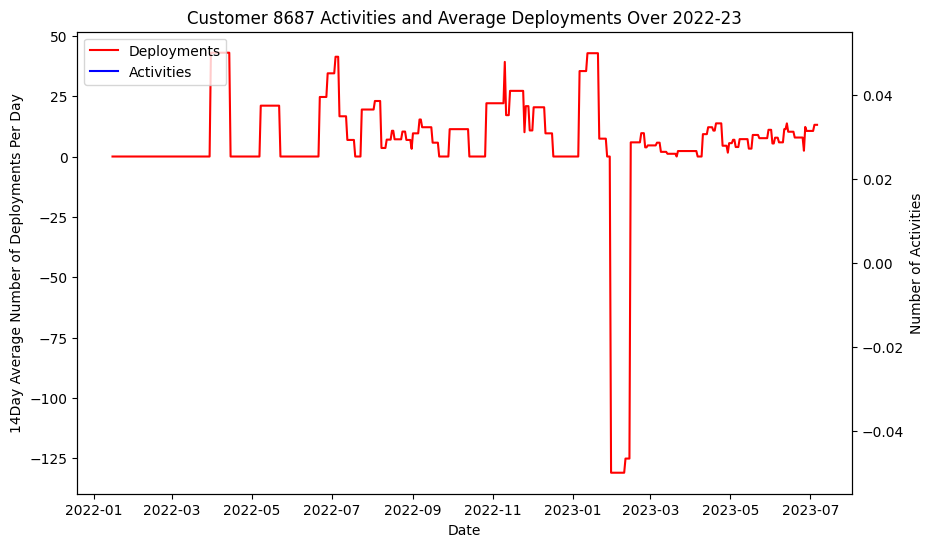

C:\Users\nmathur\AppData\Local\Temp\ipykernel_21896\59215926.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deps['NUM_DEPS'] = ([json.loads(x)['cumulative_value'] for x in deps["FEATURE_JSON"]])


<Figure size 640x480 with 0 Axes>

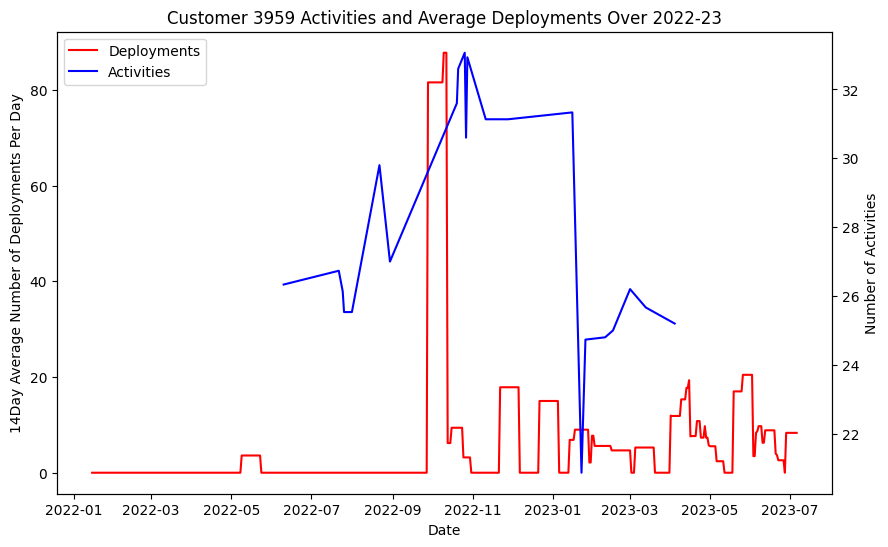

C:\Users\nmathur\AppData\Local\Temp\ipykernel_21896\59215926.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deps['NUM_DEPS'] = ([json.loads(x)['cumulative_value'] for x in deps["FEATURE_JSON"]])


<Figure size 640x480 with 0 Axes>

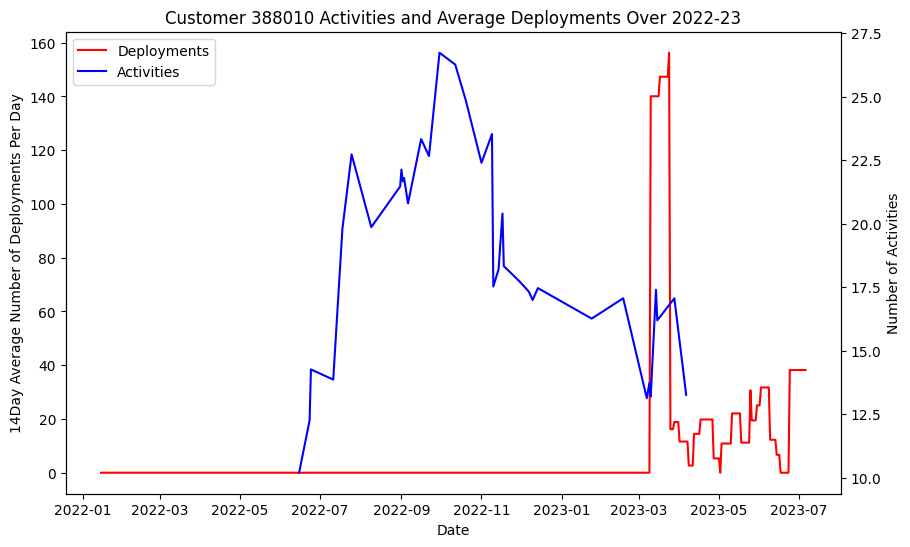

C:\Users\nmathur\AppData\Local\Temp\ipykernel_21896\59215926.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deps['NUM_DEPS'] = ([json.loads(x)['cumulative_value'] for x in deps["FEATURE_JSON"]])


<Figure size 640x480 with 0 Axes>

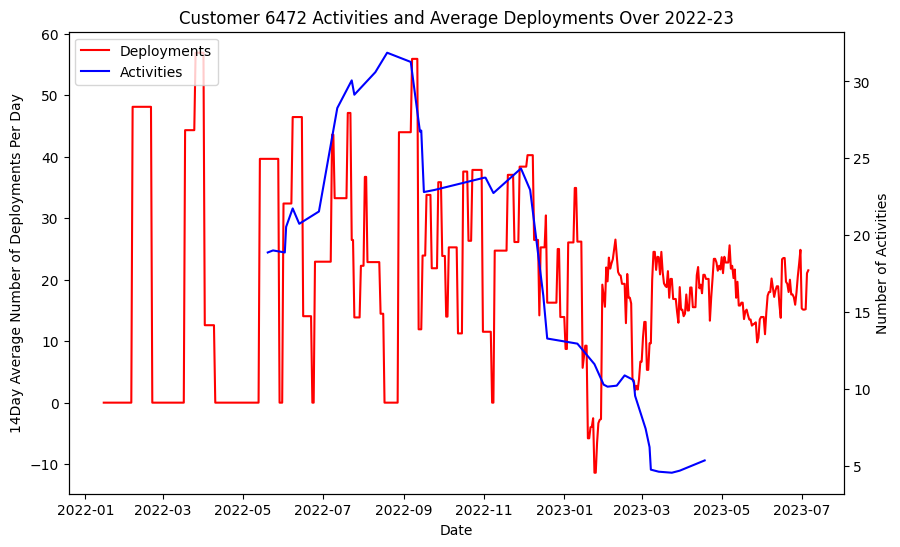

In [256]:
# Moving averages for top 5 deployments
customers = df_top_deps["CUSTOMER"].unique()

for customer in customers:

    df = df_top_deps[df_top_deps['CUSTOMER'] == customer]
    deps = df[df['ACTIVITY'] == 'gs_deployment']
    acts = df[df['ACTIVITY'] != 'gs_deployment']

    # act
    acts = acts.groupby(by=['TS']).ACTIVITY.count().reset_index()

    # deps
    deps['NUM_DEPS'] = ([json.loads(x)['cumulative_value'] for x in deps["FEATURE_JSON"]])
    deps = deps.groupby(by=['CUSTOMER','TS']).NUM_DEPS.sum().reset_index()
    deps['NUM_DEPS'] = pd.to_numeric(deps['NUM_DEPS'])
    deps["DAY_DIFFS"] = deps.groupby(by=['CUSTOMER']).NUM_DEPS.diff().fillna(0)

    dates = pd.Series(df_all_acts["TS"].unique(), name="TS")
    companies = pd.Series(deps["CUSTOMER"].unique(), name="CUSTOMER")
    combined = pd.merge(dates, companies, how='cross')
    combined = combined.sort_values(by=['CUSTOMER', 'TS'])
    deps['TS'] = pd.to_datetime(deps['TS'])
    combined = pd.merge(combined, deps, left_on=["CUSTOMER", "TS"], right_on=["CUSTOMER", "TS"], how='left').fillna(0)

    days = 14
    s = days // 2

    combined['avgs'] = combined.groupby('CUSTOMER')['DAY_DIFFS'].shift(-s).rolling((2*s)+1).mean().reset_index(0, drop=True)
    final = combined.groupby(by=['TS']).avgs.sum().reset_index()
    
    # activity avgs
    acts['avgs'] = acts['ACTIVITY'].shift(-s).rolling((2*s)+1).mean().reset_index(0, drop=True)

    acts['TS'] = pd.to_datetime(acts['TS'])
    final['TS'] = pd.to_datetime(final['TS'])

    plt.clf()
    plt.rcdefaults()
    fig,ax = plt.subplots()
    fig.set_size_inches(10, 6)
    l1 = ax.plot(final['TS'][days:-days], final["avgs"][days:-days], color='red', label='Deployments')
    ax.set_xlabel('Date')
    ax.set_ylabel(str(days) + 'Day Average Number of Deployments Per Day')
    ax2=ax.twinx()
    l2 = ax2.plot(acts['TS'], acts["avgs"], color='blue', label='Activities')
    ax2.set_ylabel("Number of Activities")
    ax.set_title('Customer ' + str(customer) + ' Activities and Average Deployments Over 2022-23')
    lns = l1 + l2
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc='upper left')
    plt.show()
    fig.savefig('Visualizations/Top_5_deps_' + str(days) + '_Day_Customer_' + str(customer) + '_Deployments_and_Activities_2022_23')
    
    

